In [1]:
import sys, os, itertools, sklearn
sys.path.append('/home/roquero/CausalAggregation/Code')
import pandas as pd
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn import datasets
from sklearn.metrics import auc
from scipy.interpolate import UnivariateSpline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True, edgeitems=10)
np.core.arrayprint._line_width = 80

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
from backfitting import Backfitting
from boosting import Boosting
from base_environment import BaseEnvironment
from collection_environment import CollectionEnvironment
from regression_method import PolynomialRegression, RandomForestRegression, DecisionTreeRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


/home/roquero/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
ik_h, se_h = [], (lambda input_samples:input_samples)
ik_x1, se_x1 = ['h'], (lambda input_samples: 2*input_samples[0] + input_samples[1])
ik_x2, se_x2 = ['h', 'x1'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x3, se_x3 = ['x1', 'x2'], (lambda input_samples: -input_samples[0] * 2*input_samples[1] + input_samples[2])
ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: np.log(1+np.abs(input_samples[0])) + input_samples[1] + input_samples[2])

ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
                                         0.5*input_samples[0] 
                                         + (input_samples[1]>0)*1.
                                        + (input_samples[2]>0)*1.
                                         - (input_samples[2]>0)*(input_samples[3]<-1)*5.
                                         + (input_samples[1]<0)*(input_samples[4]<-1)*2.
                                         + (input_samples[1]<0)*(input_samples[2]<1)*(input_samples[3]<-1)*3.
                                         + 0.3*input_samples[5])
ik_x5, se_x5 = ['x2', 'x4', 'y'], (lambda input_samples: 2*input_samples[0] + input_samples[1] - input_samples[2] + input_samples[3])

In [35]:
fh = {'input_keys':ik_h, 'structural_eq': se_h}
f1 = {'input_keys':ik_x1, 'structural_eq': se_x1}
f2 = {'input_keys':ik_x2, 'structural_eq': se_x2}
f3 = {'input_keys':ik_x3, 'structural_eq': se_x3}
f4 = {'input_keys':ik_x4, 'structural_eq': se_x4}
f5 = {'input_keys':ik_x5, 'structural_eq': se_x5}
fy = {'input_keys':ik_y, 'structural_eq': se_y}

sh = lambda n_samples: np.random.normal(size=n_samples)
s1 = lambda n_samples: np.random.normal(size=n_samples)
s2 = lambda n_samples: np.random.normal(size=n_samples)
s3 = lambda n_samples: np.random.normal(size=n_samples)
s4 = lambda n_samples: np.random.normal(size=n_samples)
s5 = lambda n_samples: np.random.normal(size=n_samples)
sy = lambda n_samples: np.random.normal(size=n_samples)

topo_order = ['h','x1','x2','x3','x4','y','x5']
y_key = 'y'
x_key = ['x1','x2','x3','x4','x5']

structural_equation_dict = {'x1':f1, 'x2':f2, 'x3':f3, 'y':fy, 'x4':f4, 'x5':f5, 'h':fh}
disturbance_sampler_dict = {'x1':s1, 'x2':s2, 'x3':s3, 'y':sy, 'x4':s4, 'x5':s5, 'h':sh}

base = BaseEnvironment(structural_equation_dict, disturbance_sampler_dict, topo_order, y_key, x_key)
coll_env = CollectionEnvironment(base)

coll_env.add_env('e1', {'x1':{'type':'independent'},'x2':{'type':'independent'},'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e2', {'x1':{'type':'independent'},'x4':{'type':'independent'}}, 10000)
coll_env.add_env('e3', {'x2':{'type':'independent'},'x3':{'type':'independent'}}, 10000)

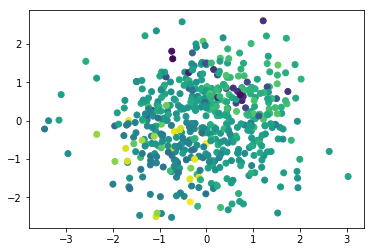

In [36]:
plt.scatter(coll_env.env['e1'].data['X'][0,:500],coll_env.env['e1'].data['X'][1,:500], c=coll_env.env['e1'].data['Y'][:500])

In [37]:
params_method = {
                 'min_impurity_decrease':0.005,
                }

backfit = Backfitting(DecisionTreeRegression, 
                      'boosting',
                      max_n_iter=10,
                      gap_convergence=1e-5,
                      warm_start=False, 
                      params_method=params_method,
                      reweighting_candidates=True,
                      update_within_loop=False
                     )

res = backfit.fit(coll_env)
print(res)

100%|██████████| 10/10 [00:00<00:00, 17.74it/s]

[0.2784832976240429, 0.15126228926422627, 0.047383931691516334, 0.04766286388373095, 0.04740917453386813, 0.04766286388373103, 0.04740917453386811, 0.047662863883730984, 0.047409174533868094, 0.047662863883730915]


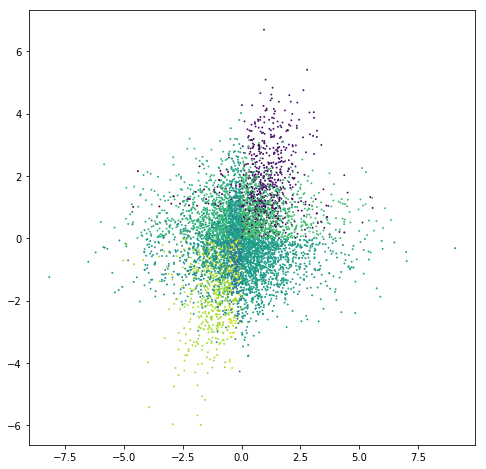

In [38]:
results = backfit.output_function_dict['e1'](backfit.x_val_full[0:3,:].T)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(backfit.x_val_full[0,:],backfit.x_val_full[1,:], c=results, s=0.8)

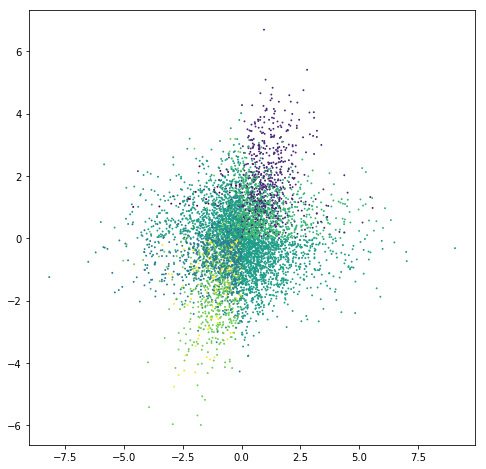

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(backfit.x_val_full[0,:],backfit.x_val_full[1,:], c=backfit.y_val_true, s=0.8)

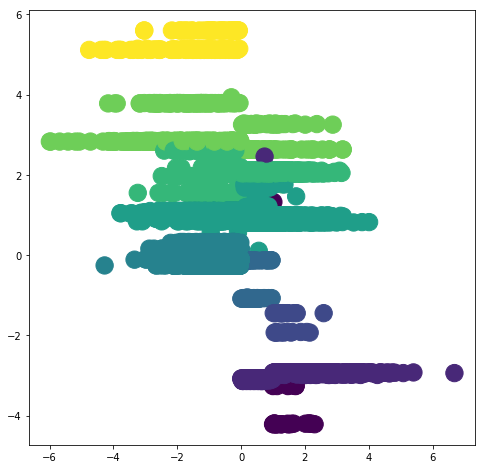

In [40]:
results = backfit.return_results()
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(results[:,1],results[:,-1], c=results[:,5],s=300)

In [41]:
backfit.evaluate_gap()
backfit.print_val()

0.047662863883730915

summary [[-1.693 0.849 -0.173 1.673 2.994 1.000 1.346 0.966]
 [1.584 0.208 -0.238 1.458 -0.645 2.000 1.432 2.094]
 [-0.023 -1.145 -0.585 0.850 -0.586 0.000 -1.024 0.161]
 [-0.593 -0.978 0.615 2.268 -0.229 0.000 -0.454 -0.092]
 [0.823 -0.092 -0.159 0.948 0.702 1.000 1.117 1.071]
 [0.505 1.508 0.123 0.746 -0.196 2.000 3.234 2.061]
 [-2.001 -1.111 0.169 0.923 -1.669 0.000 0.234 -0.115]
 [1.026 -1.201 2.241 0.882 -3.620 1.000 1.819 1.081]
 [0.902 -0.416 0.225 1.348 -1.677 1.000 1.632 1.071]
 [0.702 2.134 -0.681 -1.639 -0.923 2.000 2.073 2.073]
 ...
 [-0.383 0.848 -1.413 0.899 5.146 -1.000 -0.962 -0.134]
 [1.016 -0.293 -0.686 -0.258 -1.849 1.000 0.549 1.081]
 [-0.537 0.873 -0.630 -0.295 0.234 1.000 1.207 0.813]
 [1.156 0.109 0.265 1.725 -0.621 2.000 2.727 2.085]
 [2.229 -1.734 -0.082 -0.532 -4.142 1.000 0.859 1.099]
 [1.233 1.085 1.842 4.252 3.977 2.000 2.547 2.094]
 [3.349 0.153 -0.125 1.197 0.662 2.000 2.786 2.103]
 [-0.761 -0.383 -0.493 -0.820 -1.664 0.000 -0.180 0.318]
 [1.291 -1.040 0.

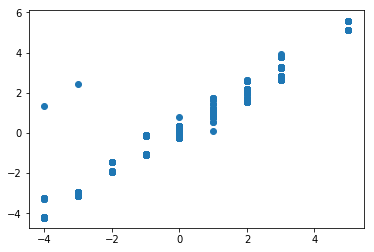

In [42]:
plt.scatter(results[:,-3], results[:,-1])